In [1]:
import numpy as np
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#!cp drive/MyDrive/Colab\ Notebooks/Data/input.zip .
#!unzip input.zip

In [ ]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.is_apple_mlc_enabled()
mlcompute.is_tf_compiled_with_apple_mlc()
mlcompute.set_mlc_device(device_name='gpu')

In [27]:
train_data = "input/Training/"
test_data = "input/Testing/"

In [28]:
img_rows, img_cols = 224, 224
batch_size = 32
classes = 4

In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=25,
                                   height_shift_range = 0.3,
                                   width_shift_range = 0.3,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = "nearest")
test_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
train_generator = train_datagen.flow_from_directory(train_data,
                                                    batch_size = batch_size,
                                                    target_size = (img_rows, img_cols),
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 2870 images belonging to 4 classes.


In [31]:
test_generator = test_datagen.flow_from_directory(test_data,
                                                batch_size = batch_size,
                                                target_size = (img_rows, img_cols),
                                                class_mode = "categorical")

Found 394 images belonging to 4 classes.


In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ZeroPadding2D,GlobalAveragePooling2D

In [33]:
vggmodel = VGG16(weights="imagenet",
                input_shape=(img_rows,img_cols,3),
                include_top=False)
for layer in vggmodel.layers:
    layer.trainable=False
    
def top_model(bottom_model,num_classes):
    top_model = bottom_model.output
    top_model = BatchNormalization()(top_model)
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation="relu")(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(512,activation="relu")(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(num_classes,activation="softmax")(top_model)
    return top_model

58892288/58889256 [==============================] - 1s 0us/step


In [34]:
FC_Head = top_model(vggmodel,classes)
vgg_model = Model(inputs = vggmodel.input, outputs = FC_Head)
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
epochs=50
train_samples = 2870
test_samples = 394
vgg_model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['acc'])

In [36]:
history_vgg = vgg_model.fit(train_generator,
                   epochs=epochs,
                   steps_per_epoch = train_samples//batch_size,
                   validation_data = test_generator,
                   validation_steps = test_samples//batch_size)

Epoch 1/50
89/89 [==============================] - 85s 521ms/step - loss: 1.3359 - acc: 0.6177 - val_loss: 1.4601 - val_acc: 0.3490
Epoch 2/50
89/89 [==============================] - 42s 470ms/step - loss: 0.6946 - acc: 0.7427 - val_loss: 1.3044 - val_acc: 0.4896
Epoch 3/50
89/89 [==============================] - 42s 467ms/step - loss: 0.6349 - acc: 0.7585 - val_loss: 1.4262 - val_acc: 0.5443
Epoch 4/50
89/89 [==============================] - 42s 466ms/step - loss: 0.4956 - acc: 0.8101 - val_loss: 1.0763 - val_acc: 0.6510
Epoch 5/50
89/89 [==============================] - 42s 469ms/step - loss: 0.5408 - acc: 0.8017 - val_loss: 1.3717 - val_acc: 0.6172
Epoch 6/50
89/89 [==============================] - 42s 470ms/step - loss: 0.4565 - acc: 0.8298 - val_loss: 1.8102 - val_acc: 0.6615
Epoch 7/50
89/89 [==============================] - 41s 465ms/step - loss: 0.4496 - acc: 0.8262 - val_loss: 2.0821 - val_acc: 0.6120
Epoch 8/50
89/89 [==============================] - 42s 469ms/step - 

In [37]:
scores=vgg_model.evaluate(test_generator,steps=test_samples//batch_size+1,verbose=1)
print("Test Accuracy: %.3f Test Loss: %.3f"%(scores[1]*100,scores[0]))

13/13 [==============================] - 5s 356ms/step - loss: 2.2508 - acc: 0.7487
Test Accuracy: 74.873 Test Loss: 2.251


In [38]:
vgg_model.save('vgg_model_brainTumor.h5')

In [39]:
classifier = vgg_model

In [40]:
test_pred = classifier.predict(test_generator,steps = test_samples//batch_size, verbose=1)
test_labels = np.argmax(test_pred,axis=1)
test_labels

12/12 [==============================] - 2s 164ms/step


array([1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 3, 1, 1, 3,
       3, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 3, 2, 1, 3, 1, 0, 3, 1,
       1, 1, 1, 2, 2, 1, 3, 2, 2, 1, 1, 3, 3, 1, 2, 3, 1, 1, 1, 2, 2, 2,
       1, 0, 3, 2, 1, 1, 0, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 2, 1, 2, 0, 3,
       3, 1, 1, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 1, 3, 1, 0, 1, 2, 2, 2, 2,
       2, 1, 1, 3, 1, 2, 3, 1, 2, 3, 1, 1, 3, 2, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 2, 1,
       2, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 2, 0, 2, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 3, 1, 1, 2, 1, 3, 1, 2, 1, 3, 2, 3, 2, 1, 2, 2, 0, 2, 0,
       1, 3, 1, 2, 3, 2, 2, 3, 1, 1, 3, 1, 1, 2, 2, 0, 1, 1, 1, 0, 3, 1,
       1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 0, 3, 1, 1, 2, 1, 3, 1, 2,
       3, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 0, 2, 2, 0, 2, 1, 1, 3, 1, 3, 3,
       1, 2, 3, 2, 2, 1, 3, 1, 2, 3, 2, 1, 1, 2, 2,

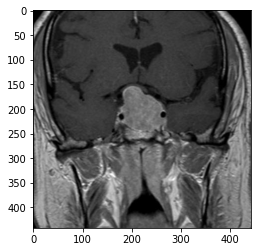

In [41]:
from PIL import Image 
from matplotlib import pyplot as plt 
IMG = Image.open('input/Testing/pituitary_tumor/image(52).jpg')
plt.imshow(IMG)
IMG = IMG.resize((224,224))
IMG = np.array(IMG)
IMG = np.true_divide(IMG,255)
IMG = IMG.reshape(1, 224,224, 3)

In [42]:
predictions = classifier.predict(IMG)
predicted_classes = np.argmax(predictions,axis=1)
print(predictions, predicted_classes)

[[1.1176252e-08 3.8662449e-02 2.3795324e-03 9.5895803e-01]] [3]


In [43]:
classes = {
    'TRAIN':['glioma_tumor', 'meningioma_tumor','no_tumor','pituitary_tumor'],
    'TEST':['glioma_tumor', 'meningioma_tumor','no_tumor','pituitary_tumor']}

predicted_class = classes['TEST'][predicted_classes[0]]
print("I think this image is among the {}.".format(predicted_class.lower()))

I think this image is among the pituitary_tumor.
